## Análise e previsão de preço do gás de cozinha

Verificar o impacto do preço de gás de cozinha no bolso do brasileiro, comparando a média do preço com o salário mínimo vigente


* Serie histórica preços GLP: https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/serie-historica-de-precos-de-combustiveis

* Série histórica salário mínimo: http://www.ipeadata.gov.br/exibeserie.aspx?stub=1&serid1739471028=1739471028


### Relatórios
* Escrever artigo sobre webscraping
* Escrever artigo sobre Prophet
* Escrever relatório do que foi analisado e previsto nesse projeto

Informação sobre o aumento do preço do gás, https://extra.globo.com/economia-e-financas/na-pandemia-preco-de-botijao-de-gas-teve-alta-de-quase-50-no-brasil-25391089.html


In [1]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from bs4 import BeautifulSoup
from prophet import Prophet



In [2]:
# utilizando webscraping extrair os links para baixar arquivos de dados sobre GLP

lista_urls = []
response = requests.get("https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/serie-historica-de-precos-de-combustiveis")

if response.status_code == 200:
    # Analisando o conteúdo HTML da página
    soup = BeautifulSoup(response.text, 'html.parser')

    # Encontrando o elemento <h3> com o texto desejado
    elemento_h3 = soup.find('h3', string='GLP P13')

    # Verificando se o elemento <h3> foi encontrado
    if elemento_h3:
        # Encontrando a lista de links abaixo do elemento <h3>
        lista_links = elemento_h3.find_next('ul').find_all('a')

        # Iterando sobre os links e extraindo a URL de cada um
        for link in lista_links:
            url_link = link.get('href')
            lista_urls.append(url_link)
    else:
        print("Elemento <h3> não encontrado.")
else:
    print("Falha ao acessar a página:", response.status_code)

print(f"Coletado {len(lista_urls)} urls")

Coletado 40 urls


In [3]:
# novos dados de 2024
lista_urls.append("https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2024/precos-glp-1.csv")
lista_urls.append("https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2024/DadosAbertosPreos2024.02GLP.csv")
lista_urls.append("https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsan/2024/precos-glp-3.csv")
lista_urls.append("https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/qus/ultimas-4-semanas-glp.csv")

In [4]:
dataframes = []
max_tentativas = 3

for url in lista_urls:

    url_valida = False
    for ano in range(2004, 2025):
        if url.find(str(ano)) > 0:
            url_valida = True
            break

    if not url_valida:
        continue

    tentativas = 0
    sucesso = False

    while tentativas < max_tentativas and not sucesso:
        tempo_inicial = datetime.now()

        # pega a última parte da url, que é o nome do arquivo
        filename = url.split("/")[-1]

        try:
            # verifica se o arquivo já existe
            df = pd.read_csv(f"./{filename}", sep=";", low_memory=False)
            sucesso = True

        # em caso de erro, baixar o arquivo
        except FileNotFoundError:
            try:
                response = requests.get(url)
                response.raise_for_status()

                with open(f"./{filename}", mode='wb') as arquivo:
                    arquivo.write(response.content)

                df = pd.read_csv(f"./{filename}", sep=";", low_memory=False)
                sucesso = True

            except Exception as e:
                tentativas += 1
                print(f"Falha ao baixar o arquivo {filename}: {e}. Tentativa {tentativas} de {max_tentativas}.")

    if sucesso:
        dataframes.append(df)
        tempo_final = datetime.now()
        print(f"{filename} concluído. Duração {tempo_final - tempo_inicial}")

    else:
        print(f"Falha ao baixar o arquivo {filename} após {max_tentativas} tentativas.")


Falha ao baixar o arquivo glp-2023-02.csv: ('Connection broken: IncompleteRead(858774 bytes read, 19466026 more expected)', IncompleteRead(858774 bytes read, 19466026 more expected)). Tentativa 1 de 3.
glp-2023-02.csv concluído. Duração 0:00:32.077289
glp-2023-01.csv concluído. Duração 0:00:27.214326
glp-2022-02.csv concluído. Duração 0:00:17.713880
precos-semestrais-glp-2022-01.csv concluído. Duração 0:00:25.035940
glp-2021-02.csv concluído. Duração 0:00:22.576488
precos-semestrais-glp2021-01.csv concluído. Duração 0:00:15.358691
glp-2020-02.csv concluído. Duração 0:00:11.796523
glp-2020-01.csv concluído. Duração 0:00:29.020134
glp-2019-02.csv concluído. Duração 0:00:29.202124
glp-2019-01.csv concluído. Duração 0:00:28.124001
glp-2018-02.csv concluído. Duração 0:00:27.558459
glp-2018-01.csv concluído. Duração 0:00:26.081402
glp-2017-02.csv concluído. Duração 0:00:19.412024
glp-2017-01.csv concluído. Duração 0:00:34.325673
glp-2016-02.csv concluído. Duração 0:00:35.747933
glp-2016-01.c

In [5]:
dados = pd.concat(dataframes)

In [6]:
# Obter o conteúdo HTML da página
response = requests.get("http://www.ipeadata.gov.br/exibeserie.aspx?stub=1&serid1739471028=1739471028")
html_content = response.content

# Analisar o HTML da página
soup = BeautifulSoup(html_content, 'html.parser')

# Encontrar a tabela pelo ID
table = soup.find('table', {'id': 'grd_DXMainTable'})

# Extrair os dados da tabela
data = []
for row in table.find_all('tr'):
    cols = row.find_all(['th', 'td'])
    cols = [col.text.strip() for col in cols]
    data.append(cols)

# Converter os dados para um DataFrame
dados_salario = pd.DataFrame(data[3:], columns=['Período', 'Salário Mínimo'])

dados_salario.tail()

,Período,Salário Mínimo
1009,2024.08,"1.412,00"
1010,2024.09,"1.412,00"
1011,2024.10,"1.412,00"
1012,2024.11,"1.412,00"
1013,2024.12,"1.412,00"


In [7]:
# filtrar os dados para retornar apenas os salários a partir de 2000
dados_salario = dados_salario.loc[dados_salario['Período'].apply(lambda x : x[:4]).astype(int) >= 2000]

In [8]:
# tratar os dados de data e valor
dados_salario['Período'] = dados_salario['Período'].str.replace(".", "-")

In [9]:
dados_salario['Salário Mínimo'] = dados_salario['Salário Mínimo'].str.replace(".", "").str.replace(",", ".").astype(float)

In [10]:
dados_salario.dtypes

Período            object
Salário Mínimo    float64
dtype: object

In [11]:
print("Dados faltantes:")
print(dados.isna().sum())

print("Dados duplicados:", dados.duplicated().sum())


Dados faltantes:
Regiao - Sigla             0
Estado - Sigla             0
Municipio                  0
Revenda                    0
CNPJ da Revenda            0
Nome da Rua                0
Numero Rua               277
Complemento          4851177
Bairro                  1038
Cep                        0
Produto                    0
Data da Coleta             0
Valor de Venda             0
Valor de Compra      4305054
Unidade de Medida          0
Bandeira                   0
dtype: int64
Dados duplicados: 0


In [12]:
dados.describe()

,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
count,6041680,6041680,6041680,6041680,6041680,6041680,6041403,1190503,6040642,6041680,6041680,6041680,6041680,1736626,6041680,6041680
unique,5,27,766,49366,51629,41088,5054,6757,15804,30648,1,4330,2378,11674,1,29
top,SE,SP,SAO PAULO,LARGO DO GÁS COMÉRCIO DE GÁS LTDA.,03.058.441/0001-32,AVENIDA BRASIL,S/N,A,CENTRO,00000-000,GLP,29/12/2014,40,26,R$ / 13 kg,BRANCA
freq,2620676,1448848,135630,10457,942,21181,1138988,104686,511051,70110,6041680,7206,436968,59270,6041680,5305821


In [13]:
# remove dados duplicados
dados.drop_duplicates(inplace=True)

In [14]:
dados = dados[["Data da Coleta", "Valor de Venda"]]
dados.head()

,Data da Coleta,Valor de Venda
0,05/07/2023,110
1,03/07/2023,103
2,05/07/2023,110
3,04/07/2023,108
4,05/07/2023,120


In [15]:
# convertendo a coluna de data para manter apenas ano e mes
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y').dt.strftime("%Y-%m")

dados['Data da Coleta']

0        2023-07
1        2023-07
2        2023-07
3        2023-07
4        2023-07
          ...   
19094    2024-03
19095    2024-03
19096    2024-03
19097    2024-03
19098    2024-03
Name: Data da Coleta, Length: 6041680, dtype: object

In [16]:
# converte o valor da coleta para tipo númerico
dados['Valor de Venda'] = dados['Valor de Venda'].apply(lambda x : x.replace("," , ".")).astype(float)

Agrupar os dados por estados e por meses, tirando a média, mediana, máximo e mínimo.

In [17]:
dados_finais = dados.groupby(by=["Data da Coleta"]).mean().reset_index()

dados_finais.rename(columns={'Valor de Venda' : 'Valor Médio', 'Data da Coleta' : "Período"}, inplace=True)
dados_finais['Valor Médio']   = dados_finais['Valor Médio'].round(2)


In [18]:
# insere os dados de salário mínimo
dados_finais = dados_finais.merge(dados_salario, how='left', on='Período')

In [19]:
#dados_previsao sera utilizado para analisar a tendencia de preço para os próximos meses
dados_previsao = dados_finais.copy()

In [20]:
dados_finais['Ano'] = dados_finais.Período.apply(lambda x : x[:4])

In [21]:
dados_finais = dados_finais.groupby('Ano').agg({'Valor Médio' : 'mean', 'Salário Mínimo' : 'max'}).reset_index()

In [22]:
dados_finais['Proporcao_Salario'] = (dados_finais['Valor Médio'] / dados_finais['Salário Mínimo'] * 100).round(2)

In [23]:
media_ano_2024 = dados_finais.loc[dados_finais.Ano == '2024'].Proporcao_Salario.mean()
media_ano_2022 = dados_finais.loc[dados_finais.Ano == '2022'].Proporcao_Salario.mean()
media_ano_2004 = dados_finais.loc[dados_finais.Ano == '2004'].Proporcao_Salario.mean()
media_ano_2014 = dados_finais.loc[dados_finais.Ano == '2014'].Proporcao_Salario.mean()

media_geral = dados_finais['Proporcao_Salario'].mean()

In [24]:
dados_finais[dados_finais['Proporcao_Salario'] == dados_finais['Proporcao_Salario'].min()]

,Ano,Valor Médio,Salário Mínimo,Proporcao_Salario
10,2014,43.601667,724.0,6.02


In [25]:
preco_2004 = dados_finais.loc[dados_finais.Ano == '2004', 'Valor Médio'].round(2).values[0]
preco_2020 = dados_finais.loc[dados_finais.Ano == '2020', 'Valor Médio'].round(2).values[0]
preco_2022 = dados_finais.loc[dados_finais.Ano == '2022', 'Valor Médio'].round(2).values[0]
preco_2024 = dados_finais.loc[dados_finais.Ano == '2024', 'Valor Médio'].round(2).values[0]
preco_2014 = dados_finais.loc[dados_finais.Ano == '2014', 'Valor Médio'].round(2).values[0]


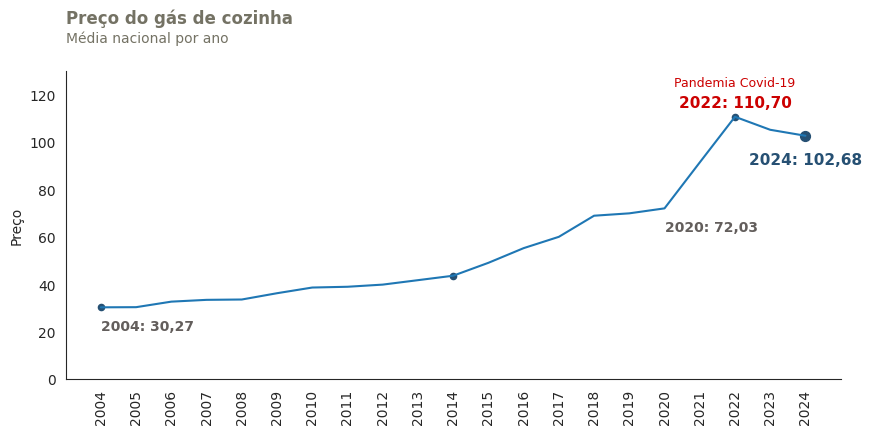

In [26]:
sns.set_style("white")
plt.figure(figsize=(10,4))

sns.lineplot(dados_finais,  x='Ano', y='Valor Médio')#, estimator="mean")

plt.scatter(x='2004', y=preco_2004, color='#265073', s=20)
plt.scatter(x='2014', y=preco_2014, color='#265073', s=20)
plt.scatter(x='2022', y=preco_2022, color='#265073', s=20)
plt.scatter(x='2024', y=preco_2024, color='#265073', s=50)

plt.text(x=-1, y = 150, s="Preço do gás de cozinha", color='#747264', size='12', weight='bold', ha='left')
plt.text(x=-1, y = 142, s="Média nacional por ano", color="#747264", size=10, ha='left')


# oculta os labels do eixo x e y
plt.xlabel(None)
plt.ylabel("Preço")

plt.text(x='2024', y=preco_2024-7, s=f"2024: {preco_2024:.2f}".replace('.', ','), size='11', weight='bold', va='top',ha='center', color="#265073")
plt.text(x='2022', y=preco_2022+13, s=f"Pandemia Covid-19", size='9', weight='normal', ha='center', color="#CC0000")
plt.text(x='2022', y=preco_2022+4, s=f"2022: {preco_2022:.2f}".replace('.', ','), size='11', weight='bold', ha='center', color="#CC0000")
plt.text(x='2020', y=preco_2020-5, s=f"2020: {preco_2020:.2f}".replace('.', ','), size='10', color="#3C3633", va='top',ha='left', weight='bold', alpha=0.8)
plt.text(x='2004', y=preco_2004-5, s=f"2004: {preco_2004:.2f}".replace('.', ','), size='10', color="#3C3633", va='top', ha='left', weight='bold', alpha=0.8)

# remove as bordas superiores e da direita do gráfico
sns.despine()#left=True, top=True, right=True, bottom=True)

# limita do eixo Y
plt.ylim(0, 130)

plt.xticks(rotation=90)

plt.show()

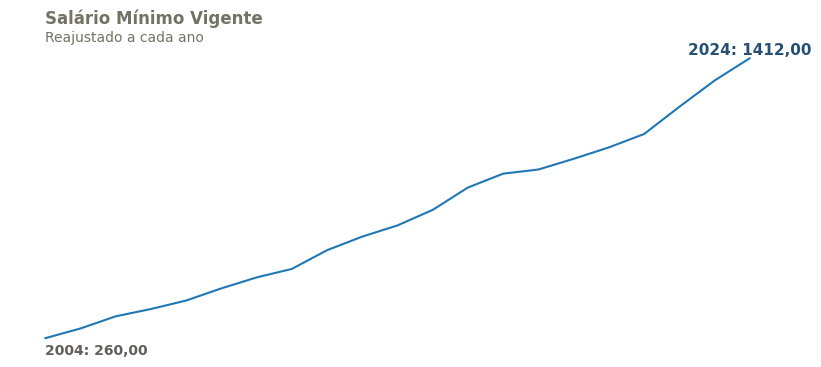

In [27]:
sns.set_style("white")
plt.figure(figsize=(10,4))

sns.lineplot(dados_finais,  x='Ano', y='Salário Mínimo')#, estimator="mean")

plt.text(x=0, y = dados_finais['Salário Mínimo'].max() * 1.1, s="Salário Mínimo Vigente", color='#747264', size='12', weight='bold', ha='left')
plt.text(x=0, y = dados_finais['Salário Mínimo'].max() * 1.05, s="Reajustado a cada ano", color="#747264", size=10, ha='left')

# # oculta os valores dos eixos
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

# # oculta os labels do eixo x e y
plt.xlabel(None)
plt.ylabel(None)

salario_2004 = dados_finais.loc[dados_finais['Ano'] == '2004', 'Salário Mínimo'].round(2).values[0]
salario_2014 = dados_finais.loc[dados_finais['Ano'] == '2014', 'Salário Mínimo'].round(2).values[0]
salario_2022 = dados_finais.loc[dados_finais['Ano'] == '2022', 'Salário Mínimo'].round(2).values[0]
salario_2024 = dados_finais.loc[dados_finais['Ano'] == '2024', 'Salário Mínimo'].round(2).values[0]

plt.text(x='2024', y=salario_2024 * 1.01, s=f"2024: {salario_2024:.2f}".replace('.', ','), size='11', weight='bold', ha='center', color="#265073")
plt.text(x='2004', y=salario_2004 * 0.75, s=f"2004: {salario_2004:.2f}".replace('.', ','), size='10', color="#3C3633", ha='left', weight='bold', alpha=0.8)

# # remove as bordas superiores e da direita do gráfico
sns.despine(left=True, top=True, right=True, bottom=True)

plt.show()

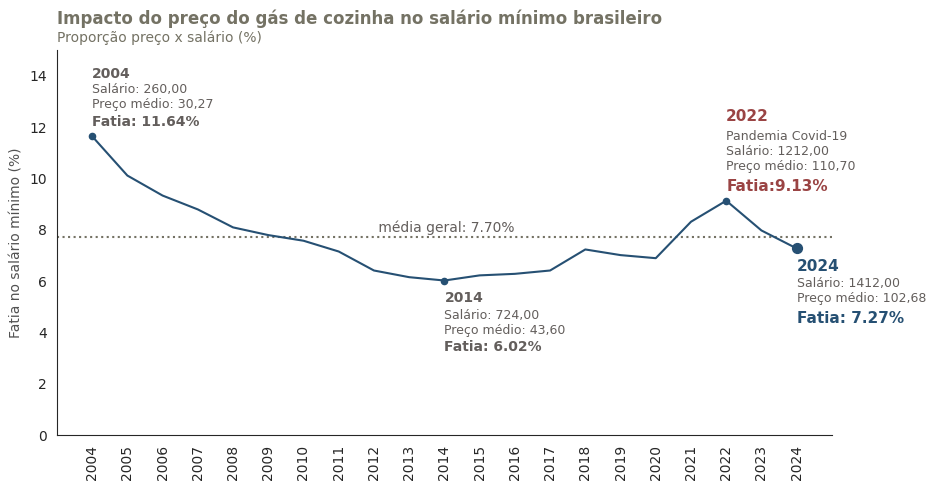

In [28]:
sns.set_style("white")
plt.figure(figsize=(10,5))

# linha pontilhada com a média geral
plt.axhline(media_geral, color='#747264', linestyle=':')
plt.text(x='2014', y=media_geral+0.2, s=f" média geral: {media_geral:.2f}%", size='10', color="#3C3633",ha='center', alpha=0.8)

# linha temporal de dados
sns.lineplot(data=dados_finais, x='Ano', y='Proporcao_Salario', estimator="mean", color='#265073')

plt.scatter(x='2004', y=media_ano_2004, color='#265073', s=20)
plt.scatter(x='2014', y=media_ano_2014, color='#265073', s=20)
plt.scatter(x='2022', y=media_ano_2022, color='#265073', s=20)
plt.scatter(x='2024', y=media_ano_2024, color='#265073', s=50)

plt.text(x=-1, y = 16, s="Impacto do preço do gás de cozinha no salário mínimo brasileiro", color='#747264', size='12', weight='bold', ha='left')
plt.text(x=-1, y = 15.3, s="Proporção preço x salário (%)", color="#747264", size=10, ha='left')

# plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

plt.xlabel(None)
plt.ylabel("Fatia no salário mínimo (%)", alpha=0.8)

plt.text(x='2024', y=media_ano_2024-1.1, s=f"Salário: {salario_2024:.2f}\nPreço médio: {dados_finais['Valor Médio'][dados_finais.Ano == '2024'].mean():.2f}".replace('.', ','), size='9', color="#3C3633", va='top', ha='left', weight='normal', alpha=0.8)
plt.text(x='2024', y=media_ano_2024-0.4, s=f"2024\n\n\nFatia: {media_ano_2024:.2f}%", size='11', weight='bold', va='top', ha='left', color="#265073")

plt.text(x='2022', y=media_ano_2022+1.2, s=f"Pandemia Covid-19\nSalário: {salario_2022:.2f}\nPreço médio: {dados_finais['Valor Médio'][dados_finais.Ano == '2022'].mean():.2f}".replace('.', ','), size='9', color="#3C3633", ha='left', weight='normal', alpha=0.8)
plt.text(x='2022', y=media_ano_2022+0.4, s=f"2022\n\n\n\nFatia:{media_ano_2022:.2f}%", size='11', weight='bold', ha='left', color="#9A4444")

plt.text(x='2014', y=media_ano_2014-1.1, s=f"Salário: {salario_2014:.2f}\nPreço médio: {dados_finais['Valor Médio'][dados_finais.Ano == '2014'].mean():.2f}".replace('.', ','), size='9', color="#3C3633", va='top', ha='left', weight='normal', alpha=0.8)
plt.text(x='2014', y=media_ano_2014-0.4, s=f"2014\n\n\nFatia: {media_ano_2014:.2f}%", size='10', color="#3C3633", va='top', ha='left', weight='bold', alpha=0.8)

plt.text(x='2004', y=media_ano_2004+1.1, s=f"\nSalário: {salario_2004:.2f}\nPreço médio: {dados_finais['Valor Médio'][dados_finais.Ano == '2004'].mean():.2f}".replace('.', ','), size='9', color="#3C3633", ha='left', weight='normal', alpha=0.8)
plt.text(x='2004', y=media_ano_2004+0.4, s=f"2004\n\n\nFatia: {media_ano_2004:.2f}%", size='10', color="#3C3633", ha='left', weight='bold', alpha=0.8)


# remove as bordas superiores e da direita do gráfico
sns.despine()#left=True, top=True, right=True, bottom=True)

# limita do eixo Y
plt.ylim(0, 15)

plt.xticks(rotation=90)

# limita o eixo X
# plt.xlim('2003', '2024')

plt.show()

## Previsão de preço para os próximos meses

In [33]:
# corrigir o tipo das colunas
dados_previsao['Valor Médio'] = dados_previsao['Valor Médio'].astype(float)
dados_previsao['Salário Mínimo'] = dados_previsao['Salário Mínimo'].astype(float)
dados_previsao['Período'] = pd.to_datetime(dados_previsao['Período'])

In [34]:
dados_previsao['Percentual'] = (dados_previsao['Valor Médio'] / dados_previsao['Salário Mínimo'] * 100).round(2)

In [289]:
def prev_proximos_meses(dados_prophet, periodos=12, freq='M', exibir_componentes=True):
    # Definindo o intervalo de datas da COVID-19
    lockdowns = pd.DataFrame([
        {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2023-06-06'}
    ])

    for t_col in ['ds', 'ds_upper']:
        lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
    lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

    # Adicionando o intervalo de datas da COVID-19 ao modelo Prophet
    modelo = Prophet(holidays=lockdowns)

    modelo.fit(dados_prophet)

    future = modelo.make_future_dataframe(periods=periodos, freq=freq)

    forecast = modelo.predict(future)

    if exibir_componentes:
        # tendencia
        modelo.plot(fcst=forecast[-24:])
        plt.show()

        # componentes
        modelo.plot_components(fcst=forecast)
        plt.show()

    return forecast

In [324]:
# Previsão percentual para os próximos 12 meses
dados_prophet = pd.DataFrame(data=dados_previsao[['Período', 'Percentual']].values, columns=['ds', 'y'])

forecast = prev_proximos_meses(dados_prophet, periodos=10, exibir_componentes=False)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplx4ea7rc/n46jb2_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplx4ea7rc/xpodfrjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82152', 'data', 'file=/tmp/tmplx4ea7rc/n46jb2_s.json', 'init=/tmp/tmplx4ea7rc/xpodfrjg.json', 'output', 'file=/tmp/tmplx4ea7rc/prophet_model94w8pmcv/prophet_model-20240424203619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


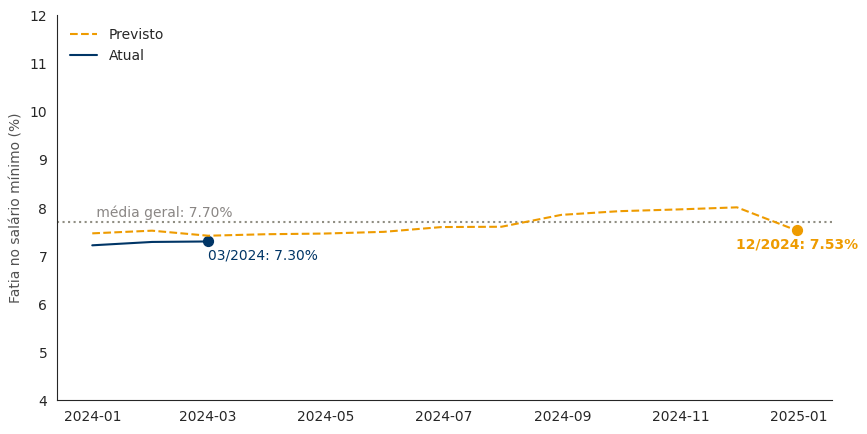

In [325]:

# gráfico com a previsão para os próximos meses
sns.set_style("white")
plt.figure(figsize=(10,5))

cor_azul = "#003566"
cor_laranja = "#ee9b00"

# exibe informação da média geral
plt.text(x=forecast.loc[forecast['ds'] == '2024-01-01', 'ds'].values[0], y=media_geral+0.1, s=f" média geral: {media_geral:.2f}%", size='10', color="#3C3633",ha='left', alpha=0.6)
plt.axhline(media_geral, color='#747264', linestyle=':', alpha=0.8)

# exibe informação sobre valores previstos
sns.lineplot(forecast.loc[forecast['ds'].dt.year >= 2024], x='ds', y='yhat', color=cor_laranja, linestyle='--', label='Previsto')

x = forecast['ds'][-1:].values[0]
y = forecast['yhat'][-1:].values[0]

plt.scatter(x, y, color=cor_laranja, s=50)
plt.text(x=x, y=y*0.98, s=f"{pd.to_datetime(x).strftime('%m/%Y')}: {y:.2f}%", size='10', color=cor_laranja, va='top', weight='bold',ha='center', alpha=1)

# exibe informação sobre valores reais
sns.lineplot(dados_previsao.loc[dados_previsao['Período'].dt.year >= 2024], color=cor_azul, x='Período', y='Percentual', label='Atual')

x = dados_previsao['Período'][-1:].values[0]
y = dados_previsao['Percentual'][-1:].values[0]

plt.scatter(x, y, s=50, color=cor_azul)
plt.text(x=x, y=y*0.98, s=f"{pd.to_datetime(x).strftime('%m/%Y')}: {y:.2f}%", size='10', va='top', ha='left', alpha=1, color=cor_azul)


# limita a altura do eixo y
plt.ylim(4,12)

# labels dos eixos x e y
plt.ylabel("Fatia no salário mínimo (%)", alpha=0.8)
plt.xlabel(None)

# titulo do gráfico
# plt.title("Tendência de preço para os próximos meses")

# remove as barras top e right do gráfico
sns.despine()

# remove a moldura da legenda e posiciona na parte de cima e a esquerda, no gráfico
plt.legend(frameon=False, loc='upper left')

# exibe o gráfico
plt.show()

In [ ]:
# Previsão de preço para os próximos 12 meses
dados_prophet = pd.DataFrame(data=dados_previsao[['Período', 'Valor Médio']].values, columns=['ds', 'y'])
forecast = prev_proximos_meses(dados_prophet, periodos=10, exibir_componentes=False)


In [333]:
dados_previsao['Período'][dados_previsao['Período'].dt.year >= 2024][:1].values[0]

numpy.datetime64('2024-01-01T00:00:00.000000000')

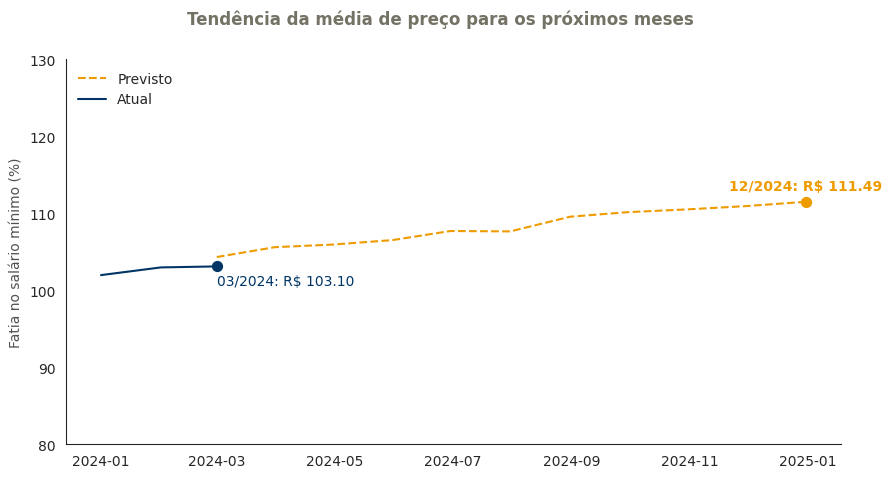

In [341]:

# gráfico com a previsão para os próximos meses
sns.set_style("white")
plt.figure(figsize=(10,5))

cor_azul = "#003566"
cor_laranja = "#ee9b00"

# exibe informação sobre valores previstos
sns.lineplot(forecast.loc[forecast['ds'].dt.year >= 2024][2:], x='ds', y='yhat', color=cor_laranja, linestyle='--', label='Previsto')

x = forecast['ds'][-1:].values[0]
y = forecast['yhat'][-1:].values[0]

plt.scatter(x, y, color=cor_laranja, s=50)
plt.text(x=x, y=y*1.01, s=f"{pd.to_datetime(x).strftime('%m/%Y')}: R$ {y:.2f}", size='10', color=cor_laranja, va='bottom', weight='bold',ha='center', alpha=1)


# exibe informação sobre valores reais
sns.lineplot(dados_previsao.loc[dados_previsao['Período'].dt.year >= 2024], color=cor_azul, x='Período', y='Valor Médio', label='Atual')

x = dados_previsao['Período'][-1:].values[0]
y = dados_previsao['Valor Médio'][-1:].values[0]

plt.scatter(x, y, s=50, color=cor_azul)
plt.text(x=x, y=y*0.99, s=f"{pd.to_datetime(x).strftime('%m/%Y')}: R$ {y:.2f}", size='10', va='top', ha='left', alpha=1, color=cor_azul)


# limita a altura do eixo y
plt.ylim(80,130)

# labels dos eixos x e y
plt.ylabel("Fatia no salário mínimo (%)", alpha=0.8)
plt.xlabel(None)

# titulo do gráfico
plt.suptitle("Tendência da média de preço para os próximos meses", color='#747264', size='12', weight='bold', ha='center')
plt.title("", color='#747264', size='12', weight='bold', ha='right')

# remove as barras top e right do gráfico
sns.despine()

# remove a moldura da legenda e posiciona na parte de cima e a esquerda, no gráfico
plt.legend(frameon=False, loc='upper left')

# exibe o gráfico
plt.show()